# Variational Algorithms for Energy Minimization

### Dr. Stefano Gogioso (University of Oxford)

In [3]:
%matplotlib inline
import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import networkx as nx
import math
from math import pi, sqrt
from cmath import exp
from itertools import product
np.set_printoptions(floatmode="fixed", precision=3, sign="+", suppress=True)
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Imports and utility functions from (previous) notebooks:

In [4]:
from qiskit_utils import *
from qiskit.algorithms.optimizers import COBYLA, ADAM, SPSA

In [5]:
simulator = AerSimulator() # noiseless simulator
theta = Parameter("θ")
phi = Parameter("φ")
lam = Parameter("λ")

Disable a deprecation warning arising from `plt.xticks([])`.

In [6]:
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

### VQE

The [Variational Quantum Eigensolver](https://arxiv.org/abs/1304.3061) attempts to find a state of minimum energy for a given Hamiltonian, by using variational quantum circuits to explore that space of states and the expectation value of the Hamiltonian itself as cost function during optimization. The [Variational Quantum Thermalizer](https://arxiv.org/abs/1910.02071) is a generalisation to non-zero system temperatures.
See also [Quantum Chemistry in the Age of Quantum Computing](https://arxiv.org/abs/1812.09976).

<div style="display: flex; flex-direction: row;">
<img src="images/vqe1.jpg" alt="" width="50%"/>
<img src="images/vqe2.jpg" alt="" width="50%"/>
</div>
(Left: minimum energy for He-H$^+$ at R=90pm molecular separation. Right: bonding dissociation curve for He-H$^{+}$. Courtesy of <a href="https://arxiv.org/abs/1304.3061">arXiv:1304.3061</a>)

### QAOA

The [Quantum Approximate Optimisation Algorithm](https://arxiv.org/abs/1411.4028) attempts to find optimal solutions to discrete optimization problems, simulating a time-dependent Hamiltonian using [Trotterisation](https://en.wikipedia.org/w/index.php?title=Suzuki-Trotter_decomposition) and variational quantum circuits. A specialised application of QAOA is given by [Variational Quantum Factoring](https://arxiv.org/abs/1808.08927), a gate-based analogue of [Quantum Annealing for Prime Factorisation](https://www.nature.com/articles/s41598-018-36058-z).

<div style="display: flex; flex-direction: row;">
<img src="images/qaoa_maxcut_partition1.png" alt="Max-cut Example" width="40%"/>
<img src="images/qaoa_maxcut_sol.jpg" alt="Max-cut solution" width="60%"/>
</div>
(Left courtesy of <a href="https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html">PennyLane</a>)

## Observables

In quantum theory, the notion of **observable** is typically defined to mean some assignment of distinct real values $q_k \in \mathbb{R}$ to the outcomes of some projective quantum measurement $(\Pi_k)_{k}$:

- The real values $q_k$ are the observable **quantities**, or **(eigen)values**. They are typically "quantized" i.e. discrete (or even finite).
- The projector $\Pi_k$ defines the **eigenspace** for value $q_k$, the complex sub-space of pure quantum states on which the observable takes the value $q_k$ with certainty. They are orthogonal and idempotent (i.e. $\Pi_k \Pi_{k'} = \delta_{k,k'}\Pi_k$) and they form a decomposition of the identity (i.e. $\sum_k \Pi_k = I$).  States $|\psi\rangle$ in the subspaces (i.e. $\Pi_k |\psi\rangle = |\psi\rangle$) are known as **eigenstates**.

Because observables are (typically assumed to be) real-valued, we can consider the expectation value of an arbitrary observable on a quantum state $\rho$, where $\mathbb{P}(k|\rho)$ is the probability of outcome $k$ for the projective measurement $(\Pi_k)_{k}$ on state $\rho$:

$$
\langle O \rangle_{\rho}
:=
\sum_{k} q_k \mathbb{P}(k|\rho)
$$

Because of the [spectral theorem](https://en.wikipedia.org/wiki/Spectral_theorem#Finite-dimensional_case), observables on $n$ qubits can be identified with self-adjoint matrices $O \in \mathbb{C}^{2^n\times 2^n}$, whence comes the eigenspace/eigenvalue nomenclature:

$$
    O = \sum_{k} q_k \Pi_k
$$

For the projectors $\Pi_k$ themselves, the expectation value is simply the measurement outcome probability, which can be computed theoretically using the trace:

$$
\langle\Pi_k\rangle_\rho
=
\mathbb{P}(k|\rho)
:=
\text{Tr}\left(\Pi_k \rho\right)
$$

When $\rho = |\psi\rangle\langle\psi|$ is a pure state, this simplifies to the [Born rule](https://en.wikipedia.org/wiki/Born_rule):

$$
\mathbb{P}(k|\rho)
=
\text{Tr}\left(\Pi_k |\psi\rangle\langle\psi|\right)
=
\text{Tr}\left(\langle\psi|\Pi_k |\psi\rangle\right)
=
\langle\psi|\Pi_k |\psi\rangle
$$


Self-adjoint matrices are naturally complex-valued, i.e. they live in $\mathbb{C}^{2^n\times 2^n}$.
However, they also form a real vector space, with the $n$-qubit products $\otimes_{q=0}^{n-1} P_{q_i}$ of [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrix) $P_q \in \{\text{I}, \text{X}, \text{Y}, \text{Z}\}$ as a basis and real coeffients $O_\underline{P} \in \mathbb{R}$:

$$
    O
    \hspace{1mm}
    =
    \hspace{-3mm}
    \sum_{\underline{P} \in \{\text{I}, \text{X}, \text{Y}, \text{Z}\}^n}
    \hspace{-3mm}
    O_\underline{P}\;
    \bigotimes_{q=0}^{n-1} P_{q_i}
$$

As a consequence, we get a generic practical way to compute the expectation values of arbitrary observables $O$ on a quantum state $\rho$, by taking linear combination of the expectation values for Pauli observables obtained through tomography:

$$
\langle O \rangle_{\rho}
\hspace{1mm}
=
\hspace{-3mm}
\sum_{\underline{P} \in \{\text{I}, \text{X}, \text{Y}, \text{Z}\}^n}
\hspace{-3mm}
O_\underline{P}\;
\left\langle
\bigotimes_{q=0}^{n-1} P_{q_i}
\right\rangle_{\!\!\rho}
\hspace{1mm}
=
\hspace{-2mm}
\sum_{\underline{P} \in \{\text{I}, \text{X}, \text{Y}, \text{Z}\}^n}
\hspace{-3mm}
O_\underline{P}\;
\rho_{\underline{P}}
$$

For example, below is the energy observable for the $H_2$ molecule in the 2-qubit approximation from <a href="https://arxiv.org/abs/1704.05018">arXiv:1704.05018</a>. Since we can obtain $\text{IZ}$ and $\text{ZI}$ by marginalising $\text{ZZ}$, we only need to perform 2 out of the 15 possible Pauli measurements on 2 qubits ($\text{ZZ}$ and $\text{XX}$):

$$
H
=
0.011\,\text{Z}_{q_0}\text{Z}_{q_1}
+0.398\,\text{Z}_{q_0}
+0.398\,\text{Z}_{q_1}
+0.011\,\text{X}_{q_0}\text{X}_{q_1}
$$

In [4]:
H = {
    "ZZ": 0.011,
    "IZ": 0.398,
    "ZI": 0.398,
    "XX": 0.181
}

In [5]:
def obs_expval(state_prep: QuantumCircuit, obs: Mapping[str, float], **kwargs) -> float:
    circ = state_prep.copy(); n = state_prep.num_qubits
    assert all(len(paulis) == n for paulis in obs)
    # tomography of required Paulis:
    required_paulis_list = sorted({paulis.replace("I", "Z") for paulis in obs
                                   if not all(p == "I" for p in paulis)})
    circ.add_register(ClassicalRegister(n))
    tomography_circuits = {paulis: circ.compose(pauli_meas(paulis))
                           for paulis in required_paulis_list}
    batch = list(tomography_circuits.values())
    job = execute(batch, **kwargs)
    counts_list = job.result().get_counts()
    tomography_counts = dict(zip(tomography_circuits.keys(), counts_list))
    # fill in remaining Paulis by marginalisation:
    for paulis in set(obs)-set(tomography_counts)-{"I"*n}:
        qubits_to_measure = [q for q in range(n) if paulis[n-1-q] != "I"]
        full_counts = tomography_counts[paulis.replace("I", "Z")]
        tomography_counts[paulis] = marginal_counts(full_counts, qubits_to_measure)
    # compute expectation values:
    expvals = {"I"*n: 1.0} | {
        paulis: expval(counts)
        for paulis, counts in tomography_counts.items()
    }
    return sum(obs_val*expvals[paulis] for paulis, obs_val in obs.items())

We use our newly defined `obs_expval` to compute the expectation value of $\frac{1}{\sqrt{2}}(\text{X}+\text{Z})$ on the state halfway betweek $|0\rangle$ and $|\!+\!\rangle$, from our previous discusion of the parameter shift rule.

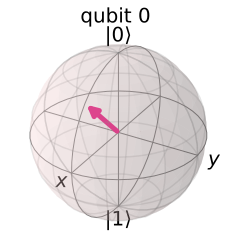

Expval of 1/sqrt(2)(X+Z) = 1.023


In [6]:
obs = {"X": 1/sqrt(2), "Y": 0, "Z": 1/sqrt(2)}
state_prep = QuantumCircuit(1)
state_prep.ry(pi/4, 0)
display(plot_bloch_multivector(state_prep))
ev = obs_expval(state_prep, obs, backend=simulator)
print(f"Expval of 1/sqrt(2)(X+Z) = {ev:.3f}")

## Hamiltonians

An important special case of observables is given by **Hamiltonians**, the energy observables $H$ that govern the unitary dynamics of quantum systems:

$$
|\psi_t\rangle
=
U(t)|\psi_0\rangle
\hspace{2cm}
U(t)
:=
e^{-i 2\pi \frac{tH}{h}}
\hspace{2cm}
\frac{d}{dt}U(t)
=
-i 2\pi \frac{H}{h}U(t)
$$

The $h$ coefficient is known as [Plank constant](https://en.wikipedia.org/wiki/Planck_constant#Value): its mathematical role is simply to turn the quantity $t H$&mdash;which has dimensions of angular momentum, i.e. time$\times$energy&mdash;into a dimensionless scalar, so that the following matrix exponential is well-defined (see [dimensional homogeneity](https://en.wikipedia.org/wiki/Dimensional_analysis#Dimensional_homogeneity), aka [apples and oranges](https://en.wikipedia.org/wiki/Apples_and_oranges)):

$$
e^A
:=
\sum_{k=0}^\infty \frac{1}{k!}A^k
=
\text{I} + A + \frac{1}{2}A^2 + \frac{1}{6}A^3 + ...
$$

From now on we work in "natural units", where $h := 2\pi$ (still with dimensions of angular momentum):

$$
U(t)
:=
e^{-itH}
$$

Diagonalising the Hamiltonian (i.e. writing it as a linear combination of orthogonal projectors) diagonalises the unitary evolution:

$$
H = \sum_E E \,\Pi_E
\hspace{3cm}
U(t) = \sum_E e^{-i tE} \Pi_E
$$

Since unitary matrices have phases $e^{i\theta}$ as eigenvalues, this esablishes a bijective correspondence between self-adjoint matrices (the Hamiltonians) and unitaries (the associated quantum dynamics), known as [Stone's theorem on one-parameter unitary groups](https://en.wikipedia.org/wiki/Stone%27s_theorem_on_one-parameter_unitary_groups).
This gives a concrete expression for quantum state dynamics, which you might have encountered before in the context of [Schrödinger's equation](https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation):

$$
|\psi_t\rangle
=
U(t) |\psi_0\rangle
=
\sum_E e^{-itE} \Pi_E |\psi_0\rangle
=
\sum_E e^{-itE} |\psi_0^{(E)}\rangle
$$

where $|\psi_t^{(E)}\rangle := \Pi_E |\psi_t\rangle = e^{-itE} |\psi_0^{(E)}\rangle$ is the component of $\Pi_E |\psi_t\rangle$ in the eigenspace for energy value $E$; in particular, $H |\psi_t^{(E)}\rangle = E |\psi_t^{(E)}\rangle$.

Two important applications of near-term quantum computing involve Hamiltonians:

1. Simulated evolution of quantum systems: the unitary $U(t)$ is implemented by a circuit and used to evolve an initial state $|\psi_0\rangle$ to a final state $|\psi_T\rangle$, which is then measured to compute some quantities of interest. 
2. Estimation of energy values for quantum systems: the space of states is explored by parametric circuits, to characterise the energy spectrum of the system.

The former is at the basis of the **quantum annealing algorithm (QAA)** and the **quantum approximate optimisation algorithm (QAOA)**, while the latter is the domain of the **variational quantum eigensolver (VQE)**. VQE is significantly easier to understand, so we start from that.

## Variational Quantum Eigensolver (VQE)

The [Variational Quantum Eigensolver](https://arxiv.org/abs/1304.3061) attempts to find a state of minimum energy for a given Hamiltonian $H$.
It uses a variational quantum circuit $W(\underline{\theta})$ to explore that space of states $|\psi(\underline{\theta})\rangle = W(\underline{\theta})|0\rangle$, with the expectation value $\langle H \rangle_{|\psi(\underline{\theta})\rangle}$ of the Hamiltonian as cost function to be minimised.
The optimal state $|\psi(\underline{\theta})\rangle$ is a ground state for the Hamiltonian, i.e. a state of minimum energy.

<div style="display: flex; flex-direction: row;">
<img src="images/vqe1.jpg" alt="" width="50%"/>
<img src="images/vqe2.jpg" alt="" width="50%"/>
</div>
(Left: minimum energy for He-H$^+$ at R=90pm molecular separation. Right: bonding dissociation curve for He-H$^{+}$. Courtesy of <a href="https://arxiv.org/abs/1304.3061">arXiv:1304.3061</a>)

<div style="display: flex; flex-direction: row;">
<img src="images/vqe_diagram.jpg" alt="" width="80%"/>
</div>
Courtesy of <a href="https://arxiv.org/abs/1304.3061">arXiv:1304.3061</a>

By itself, VQE is an incredibly simple algorithm: explore the space of states using the ansatz and optimize the parameters to minimize the energy of the Hamiltonian, expanded into a linear combination of Pauli observables. Figuring out what the Hamiltonian is turns out to be the tricky part, involving advanced quantum chemistry knowledge beyond the scope of this course.

Qiskit ships with a suite of tools for quantum chemistry calculations, see [the Qiskit VQE tutorial](https://qiskit.org/textbook/ch-applications/vqe-molecules.html). 

Regarding the ansatz choice, there are essentially two approaches:

- Selecting a sufficiently complex ansatz to explore the whole space of states, possibly one which is optimized for the quantum hardware: this is e.g. the approach of the Hardware Efficient (HE) Ansatz [arXiv:1704.05018](https://arxiv.org/abs/1704.05018).
- Using domain-specific quantum chemistry knowledge to design an ansatz which explores only a subspace respecting: this is e.g. the approach of the Unitary Coupled Cluster (UCC) Ansatz [arXiv:1701.02691](https://arxiv.org/abs/1701.02691)

The UCC requires Trotterization (see later) and is typically hard to compile and optimize, see [arXiv:2007.10515](https://arxiv.org/abs/2007.10515) for some recent developments (using diagrammatic methods). 

A picture summarising the hardware-efficient ansatz approach:

<div style="display: flex; flex-direction: row;">
<img src="images/vqe3.jpg" alt="" width="80%"/>
</div>
Courtesy of <a href="https://arxiv.org/abs/1704.05018">arXiv:1704.05018</a>

Potential energy surfaces calculated with the hardware-efficient ansatz:

<div style="display: flex; flex-direction: row;">
<img src="images/vqe4.jpg" alt="" width="100%"/>
</div>
Courtesy of <a href="https://arxiv.org/abs/1704.05018">arXiv:1704.05018</a>

In the example below, we adopt the second approach and construct our ansatz using domain-specific knowledge. We consider the molecular Hamiltonian for the hydrogen molecule $H_2$ in the 4-qubit [Hartree-Fock approximation](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method), using the [STO-3G minimal basis set](https://en.wikipedia.org/wiki/STO-nG_basis_sets), for 2 active electrons and 2 active orbitals. This particular description (including the ansatz) is courtesy of [PennyLane's VQE tutorial](https://pennylane.ai/qml/demos/tutorial_vqe.html).

In [7]:
h2_Hamiltonian = {
    "IIII": -0.04207897647782276,
    "ZIII": 0.17771287465139946,
    "IZII": 0.1777128746513994,
    "IIZI": -0.24274280513140462,
    "IIIZ": -0.24274280513140462,
    "ZZII": 0.17059738328801052,
    "ZIZI": 0.12293305056183798,
    "ZIIZ": 0.1676831945771896,
    "IZZI": 0.1676831945771896,
    "IZIZ": 0.12293305056183798,
    "IIZZ": 0.17627640804319591,
    "YXXY": 0.04475014401535161,
    "YYXX": -0.04475014401535161,
    "XXYY": -0.04475014401535161,
    "XYYX": 0.04475014401535161,
}

Some quantum chemistry knowledge about the electron orbitals of molecular hydrogen leads to the design of the following ansatz for the creation of $| \psi(\underline{\theta}) \rangle$:

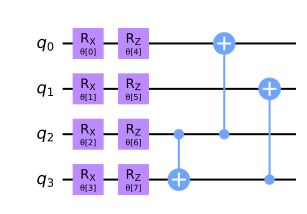

In [8]:
h2_ansatz_params = make_params(8)
h2_ansatz = QuantumCircuit(4)
for q in range(4):
    h2_ansatz.rx(h2_ansatz_params[q], q)
    h2_ansatz.rz(h2_ansatz_params[4+q], q)
h2_ansatz.cx([2, 2, 3], [3, 0, 1])
h2_ansatz.draw("mpl")

Our objective function is simply given by the expectation value of the $H_2$ Hamiltonian on the quantum state $| \psi(\underline{\theta}) \rangle$ prepared by our ansatz:

In [9]:
def make_obj_fun(ansatz, obs):
    hist = {"obj_val": [], "param_vals": []}
    def obj_fun(param_vals):
        assert len(ansatz.parameters) == len(param_vals)
        state_prep = ansatz.assign_parameters({
            p: v for p, v in zip(ansatz.parameters, param_vals)
        })
        obj_val = obs_expval(state_prep, obs, backend=simulator)
        hist["obj_val"].append(obj_val)
        hist["param_vals"].append(param_vals)
        return obj_val
    return obj_fun, hist

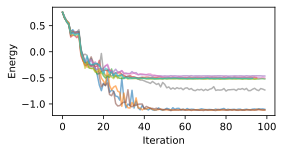

Observed minimum energies: [-1.129 -1.123 -1.121 -0.754 -0.524 -0.515 -0.508 -0.507 -0.495 -0.468]


In [10]:
rng = np.random.default_rng(seed=0)
nparams = len(h2_ansatz.parameters)
optimizer = COBYLA(maxiter=100)
min_energy_list = []; opt_param_vals_list = []
plt.figure(figsize=(4,2))
for _ in range(10):
    obj_fun, hist = make_obj_fun(h2_ansatz, h2_Hamiltonian)
    opt, e, _ = optimizer.optimize(nparams, obj_fun,
                                   initial_point=rng.uniform(-0.1, 0.1, size=nparams))
    min_energy_list.append(e); opt_param_vals_list.append(opt)
    plt.plot(hist["obj_val"], alpha=0.6)
plt.xlabel("Iteration"); plt.ylabel("Energy"); plt.show()
print("Observed minimum energies:", np.around(sorted(min_energy_list), 3))

Tomography of the ground state would reveal that it is an entangled state in the form $0.99|1100\rangle + ...$. Below we plot the (simulated) results of single-qubit tomography, showing that entanglement is minimal (arrows almost to the surface) and that $|1100\rangle$ is the major component.

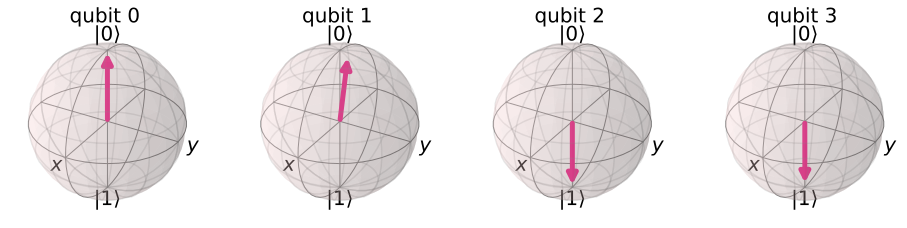

In [11]:
argmin_energy = next(i for i, x in enumerate(min_energy_list) if x == min(min_energy_list))
opt_param_vals = opt_param_vals_list[argmin_energy]
state_prep = h2_ansatz.assign_parameters(dict(zip(h2_ansatz.parameters, opt_param_vals)))
plot_bloch_multivector(state_prep)

## Simulation of Quantum Dynamics

Simulation of quantum dynamics on quantum computers requires an implementation of the unitary $U(t) = e^{-itH}$ as a circuit. When the Hamiltonian is a multiple of a single-qubit Pauli observable X, Y or Z, this is easy:

$$
e^{-i t \text{X}} = \text{RX}(2t)
\hspace{1cm}
e^{-i t \text{Y}} = \text{RY}(2t)
\hspace{1cm}
e^{-i t \text{Z}} = \text{RZ}(2t)
\hspace{1cm}
$$

In fact, knowing how to implement exponentials for the single-qubit Pauli Z observable is enough, because the other two can be obtained by conjugation. Indeed, if $B = D A D^\dagger$ then:

$$
e^B
=
\sum_{k=0}^\infty \frac{1}{k!}B^k
=
\sum_{k=0}^\infty \frac{1}{k!}\left(D A D^\dagger\right)^k
=
\sum_{k=0}^\infty \frac{1}{k!}D A^k D^\dagger
=
D e^A D^\dagger
$$

Now consider combinations of Pauli X, Y and Z observables on several qubits $q_{i_1},...,q_{i_m}$. Again, it is enough to consider the Z...Z observable on those qubits, because all other combinations can be obtained through conjugation by $\sqrt{\text{X}}$ and $\text{H}$ on the Y and X qubits respectively. We are thus interested in implementing the following unitary:

$$
\exp\left(-it \, \text{Z}_{q_{i_1}}\! \otimes ... \otimes \, \text{Z}_{q_{i_m}}\right)
$$

Luckily, the above is exactly a [_phase gadget_](https://arxiv.org/abs/1906.01734) with angle $2t$ on qubits $q_{i_1},...,q_{i_K}$. For example, below is $\exp\left(-i t \, \text{Z}_0 \otimes \text{Z}_2 \otimes \text{Z}_3\right)$ on 4 qubits.

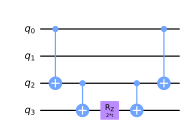

In [12]:
t = Parameter("t")
circ = QuantumCircuit(4).compose(z_phase_gadget(3, 2*t), qubits=[0,2,3])
circ.draw("mpl", scale=0.6)

Generic exponentials of (tensor products of) Pauli matrices are thus Pauli gadgets, with angle $2t$:

$$
\exp\left(-i t \, P_{q_{i_1}}\! \otimes ... \otimes \, P_{q_{i_m}}\right)
$$
For example, below is $\exp\left(-i t \, \text{Z}_0 \otimes \text{Y}_2 \otimes \text{X}_3\right)$ on 4 qubits.

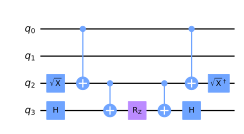

In [782]:
pauli_gadget("XYIZ", 2*t).draw("mpl", scale=0.6)

We are off to a good start: we know how to express the exponentials of Pauli observables (as Pauli gadgets), and all Hamiltonians can be written as real linear combinations of Pauli observables.

$$
H = \sum_{\underline{P}} \lambda_\underline{P} \bigotimes_{i=1}^n P_{q_i}
$$

At this point, we might wonder whether the following is true, in which case we'd be done:

$$
\exp\left(-i t H\right)
=
\prod_{\underline{P}}
\exp\left(-i t \lambda_\underline{P} \bigotimes_{i=1}^n P_{q_i}\right)
$$

Unfortunately, the above does not hold in general. 

If two matrices $A$ and $B$ commute, i.e. $AB=BA$, we have $e^{A+B} = e^Ae^B$. The three Pauli matrices $\text{X}$, $\text{Y}$ and $\text{Z}$ all commute with $\text{I}$, but any two distinct Pauli matrices anti-commute amongst themselves:

$$
\text{X}\,\text{Y} = i\text{Z}
\hspace{1cm}
\text{Y}\,\text{X} = -i\text{Z}
\hspace{1cm}
\Rightarrow
\hspace{1cm}
\text{X}\,\text{Y} = -\text{Y}\,\text{X}
$$
$$
\text{Y}\,\text{Z} = i\text{X}
\hspace{1cm}
\text{Z}\,\text{Y} = -i\text{X}
\hspace{1cm}
\Rightarrow
\hspace{1cm}
\text{Y}\,\text{Z} = -\text{Z}\,\text{Y}
$$
$$
\text{Z}\,\text{X} = i\text{Y}
\hspace{1cm}
\text{X}\,\text{Z} = -i\text{Y}
\hspace{1cm}
\Rightarrow
\hspace{1cm}
\text{Z}\,\text{X} = -\text{X}\,\text{Z}
$$

Whether two products $\bigotimes_{i=0}^{n-1}P_{q_i}$ and $\bigotimes_{i=0}^{n-1}P'_{q_i}$ commute or anti-commute depends on the number of "conflicting legs", the $i \in \{0, n-1\}$ such that $P_{q_i}, P'_{q_i} \in \{\text{X},\text{Y},\text{Z}\}$ and $P_{q_i} \neq P'_{q_i}$.

In [485]:
def comm_sign(paulis_1: str, paulis_2: str) -> int:
    n = len(paulis_1); assert len(paulis_2) == n
    conflicting_legs = [q for q in range(n)
                        if paulis_1[q] != paulis_2[q]
                        and "I" not in {paulis_1[q], paulis_2[q]}]
    return (-1)**len(conflicting_legs)
print(f"{comm_sign('XX', 'XY') = }")
print(f"{comm_sign('XX', 'YY') = }")
print(f"{comm_sign('XX', 'XI') = }")
print(f"{comm_sign('ZIZ', 'IZZ') = }")
print(f"{comm_sign('XXY', 'YXZ') = }")
print(f"{comm_sign('XXY', 'XXX') = }")

comm_sign('XX', 'XY') = -1
comm_sign('XX', 'YY') = 1
comm_sign('XX', 'XI') = 1
comm_sign('ZIZ', 'IZZ') = 1
comm_sign('XXY', 'YXZ') = 1
comm_sign('XXY', 'XXX') = -1


Back to Hamiltonians:

$$
H = \sum_{\underline{P}} \lambda_\underline{P} \bigotimes_{i=1}^n P_{q_i}
$$

If all $\underline{P}$ with $\lambda_\underline{P} != 0$ pairwise commute (i.e. $\underline{P}\underline{P'}=\underline{P'}\underline{P}$ for all $\underline{P},\underline{P'}$ such that $\lambda_\underline{P},\lambda_\underline{P'} \neq 0$), then quantum dynamics can be implemented directly as a sequential composition of Pauli gadgets:

$$
\exp\left(-i t H\right)
=
\prod_{\underline{P}}
\exp\left(-i t \lambda_\underline{P} \bigotimes_{i=1}^n P_{q_i}\right)
$$

We also refer to such Hamiltonians as **instantaneous**, because the order of the gadgets doesn't matter.

Classical examples of instantanous Hamiltonians are those where only one of $\text{X}$, $\text{Y}$ or $\text{Z}$ appear. In the context of quantum annealing and QAOA, two specific cases will are relevant:

- the **transverse field Hamiltonian** $H_{tran} = -\sum\limits_{i=0}^{n-1} X_{q_i}$
- the **problem Hamiltonians** $H_{prob} = \hspace{-3mm}\sum\limits_{I \subseteq \{0,...,n-1\}}\hspace{-3mm} c_{Q} \hspace{1mm} \bigotimes_{i \in I}\text{Z}_{q_i}$

Problem Hamiltonians are particularly useful. They have the computational basis states $|\underline{b}\rangle$ as their eigenstates, so they define energy functions $E_H:\{0,1\}^n \rightarrow \mathbb{R}$ on bitstrings $\underline{b} \in \{0,1\}^n$:

$$
E_H(\underline{b})
:=
\left\langle H_{prob} \right\rangle_{|\underline{b}\rangle}
=
\sum_{I \subseteq \{0,...,n-1\}}\hspace{-3mm} c_{Q} \hspace{1mm} \langle\underline{b}|\bigotimes_{i \in I}\text{Z}_{q_i}|\underline{b}\rangle
=
\sum_{I \subseteq \{0,...,n-1\}}\hspace{-3mm} c_{Q} \cdot(-1)^{|\{i \in I | b_i = 1\}|}
$$

In [494]:
def energy(H_prob: Mapping[str, float], bitstr: str) -> float:
    n = len(list(H_prob)[0]); assert all(len(paulis) == n for paulis in H_prob)
    assert all(all(p in {"I", "Z"} for p in paulis) for paulis in H_prob)
    assert len(bitstr) == n; assert all(b in {"0", "1"} for b in bitstr)
    e = 0.0
    for paulis, coeff in H_prob.items():
        sign = (-1)**len([q for q in range(n) if paulis[q] == "Z" and bitstr[q] == "1"])
        e += sign*coeff
    return e
print(f"{energy({'Z': 1}, '0') = }")
print(f"{energy({'Z': 1}, '1') = }")
print(f"{energy({'ZZ': 1, 'ZI': -1}, '00') = }")
print(f"{energy({'ZZ': 1, 'ZI': -1}, '01') = }")
print(f"{energy({'ZZ': 1, 'ZI': -1}, '10') = }")
print(f"{energy({'ZZ': 1, 'ZI': -1}, '11') = }")

energy({'Z': 1}, '0') = 1.0
energy({'Z': 1}, '1') = -1.0
energy({'ZZ': 1, 'ZI': -1}, '00') = 0.0
energy({'ZZ': 1, 'ZI': -1}, '01') = -2.0
energy({'ZZ': 1, 'ZI': -1}, '10') = 0.0
energy({'ZZ': 1, 'ZI': -1}, '11') = 2.0


## Problem Hamiltonians

Problem Hamiltonians provide a way to tackle boolean Constraint Satisfaction Problems on quantum computers. Given such a problem, we craft a problem Hamiltonian where energy is proportional to the number of violated constraints, and then attempt to minimize it using some variational quantum algorithm:

$$
\begin{align}
\text{energy}
&=
\text{# violated constraints}
-
\text{# satisfied constraints}
\nonumber\\
&=
2\cdot\text{# violated constraints}
-
\text{# constraints}
\nonumber\\
&=
\text{# constraints}
-2\cdot\text{# satisfied constraints}
\nonumber
\end{align}
$$

As our building blocks, for all boolean functions $\varphi: \{0,1\}^n \rightarrow \{0,1\}$ we wish to formulate Hamiltonians $H_\varphi$ such that:

$$
\left\langle H_\varphi \right\rangle_{|\underline{b}\rangle}
=
\begin{cases}
+1 &\text{ if } \varphi(\underline{b}) = 0\\
-1 &\text{ if } \varphi(\underline{b}) = 1
\end{cases}
$$

A problem is a set $\Gamma \subseteq \{0,1\}^n \rightarrow \{0,1\}$ of "constraints" to be satisfied (i.e. set to 1), and the associated problem Hamiltonian $H_\Gamma$ is:

$$
H_\Gamma
=
\sum_{\varphi \in \Gamma} H_\varphi
$$

For $\varphi(\underline{b}) := b_i$, things are really simple:

$$
\langle \text{Z}_{q_i} \rangle_{|\underline{b}\rangle}
=
\begin{cases}
+1 &\text{ if } b_i = 0\\
-1 &\text{ if } b_i = 1
\end{cases}
\hspace{1cm}
\Rightarrow
\hspace{1cm}
H_{b_i} := \text{Z}_{q_i}
$$

All boolean formulae $\varphi: \{0,1\}^n \rightarrow \{0,1\}$ can be constructed from the $b_i$ above using negation $\neg$ and conjunction $\wedge$, but we also explicitly consider xor $\oplus$ and disjunction $\vee$. For negation $\neg$, things are simple (because of the $\pm 1$ symmetry in our definition):

$$
H_{\neg \varphi}
:=
-H_{\varphi}
$$


In [1122]:
def c_bit(i: int, n: int) -> Mapping[str, float]:
    return {"I"*(n-1-i)+"Z"+"I"*i: 1}
def H_prob_validate(H: Mapping[str, float]) -> int:
    n = len(list(H)[0]); assert all(len(paulis) == n for paulis in H)
    assert all(all(p in {"I", "Z"} for p in paulis) for paulis in H)
    return n
def c_neg(H_phi: Mapping[str, float]) -> Mapping[str, float]:
    H_prob_validate(H_phi) # validation
    return {paulis: -coeff for paulis, coeff in H_phi.items()}
print(f"{c_bit(1, 4)}")
print(f"{c_neg(c_bit(3, 4))}")

{'IIZI': 1}
{'ZIII': -1}


For xor $\oplus$, we exploit the fact that $H_\varphi = H_\psi$ is equivalent to $\varphi=\psi$, which in turn is equivalent to $\varphi\oplus\psi = 0$:

$$
H_{\varphi \oplus \psi}
:=
H_\varphi H_\psi
=
\begin{cases}
+1 &\text{ if } H_\varphi = H_\psi\\
-1 &\text{ if } H_\varphi \neq H_\psi
\end{cases}
$$

When we expand the product, we might have to multiply two copies of the same $\text{Z}_{q_i}$ together: we have 

$$
\text{Z}_{q_i}\text{Z}_{q_i} = \text{I}
\hspace{2cm}
\text{I}\,\text{Z}_{q_i} = \text{Z}_{q_i} = \text{Z}_{q_i}\text{I}
$$

In [1167]:
def c_xor(H_phi: Mapping[str, float],
          H_psi: Mapping[str, float]) -> Mapping[str, float]:
    n = H_prob_validate(H_phi); assert H_prob_validate(H_psi) == n
    H = {}
    for (p_phi, c_phi), (p_psi, c_psi) in product(H_phi.items(), H_psi.items()):
        paulis = ''.join("I" if p_phi[q] == p_psi[q] else "Z" for q in range(n))
        H[paulis] = c_phi*c_psi
    return H
print(f"{c_xor(c_bit(1, 4), c_neg(c_bit(3, 4)))}")

{'ZIZI': -1}


For conjunction $\wedge$ and disjunction $\vee$ we need to take linear combinations of Hamiltonians:

In [1123]:
def H_sumprod(*Hs: Mapping[str, float],
              times: Union[float, Sequence[float]] = 1) -> Mapping[str, float]:
    if isinstance(times, (int, float)):
        times = [times]*len(Hs)
    if not Hs:
        return {}
    n = H_prob_validate(Hs[0]); assert all(H_prob_validate(H) == n for H in Hs[1:])
    H_sum = {}
    for i, H in enumerate(Hs):
        for paulis, coeff in H.items():
            H_sum[paulis] = H_sum.get(paulis, 0.0)+coeff*times[i]
    return H_sum
print(f"{H_sumprod(c_bit(1, 4), c_bit(3, 4), times=0.5)}")

{'IIZI': 0.5, 'ZIII': 0.5}


For conjunction $\wedge$, we sum multiple terms as to obtain $-1$ when $H_\varphi = -1 = H_\psi$ and $+1$ when $H_\varphi = +1$ or $H_\psi = +1$ (or both):

$$
H_{\varphi \wedge \psi}
=
\frac{1}{2}(-H_\varphi H_\psi+H_\varphi+H_\psi+1)
=
\begin{cases}
-1 &\text{ if } H_\varphi = -1 = H_\psi \\
+1 &\text{ otherwise}
\end{cases}
$$

In [1124]:
def c_and(H_phi: Mapping[str, float],
          H_psi: Mapping[str, float]) -> Mapping[str, float]:
    H_nxor = c_neg(c_xor(H_phi, H_psi)); n = len(list(H_nxor)[0])
    return H_sumprod(H_nxor, H_phi, H_psi, {"I"*n: 1}, times=0.5)
print(f"{c_and(c_bit(1, 4), c_bit(3, 4))}")

{'ZIZI': -0.5, 'IIZI': 0.5, 'ZIII': 0.5, 'IIII': 0.5}


The case of disjunction $\vee$ is analogous to conjunction:

$$
H_{\varphi \vee \psi}
=
\frac{1}{2}(H_\varphi H_\psi+H_\varphi+H_\psi-1)
=
\begin{cases}
+1 &\text{ if } H_\varphi = +1 = H_\psi \\
-1 &\text{ otherwise}
\end{cases}
$$

In [1125]:
def c_or(H_phi: Mapping[str, float],
         H_psi: Mapping[str, float]) -> Mapping[str, float]:
    H_xor = c_xor(H_phi, H_psi); n = len(list(H_xor)[0])
    return H_sumprod(H_xor, H_phi, H_psi, {"I"*n: -1}, times=0.5)
print(f"{c_or(c_bit(1, 4), c_bit(3, 4))}")
print(f"{c_neg(c_and(c_neg(c_bit(1, 4)), c_neg(c_bit(3, 4))))}")

{'ZIZI': 0.5, 'IIZI': 0.5, 'ZIII': 0.5, 'IIII': -0.5}
{'ZIZI': 0.5, 'IIZI': 0.5, 'ZIII': 0.5, 'IIII': -0.5}


Constraint satisfaction problems often involve equality constraints in the form $\varphi = \psi$. This is equivalent to $\varphi\oplus \psi = 0$, which in turn is equivalent to $\neg(\varphi\oplus \psi)$:

$$
H_{\varphi = \psi}
:=
H_{\neg(\varphi \oplus \psi)}
=
-H_{\varphi \oplus \psi}
=
-H_\varphi H_\psi
$$

In particular, for the constant equality constraints $\varphi = 0$ and $\varphi = 1$:

$$
H_{\varphi = 0} = -H_\varphi
\hspace{2cm}
H_{\varphi = 1} = H_\varphi
$$

In [1126]:
def c_eq(H_phi: Mapping[str, float],
         H_psi: Union[Mapping[str, float], str]) -> Mapping[str, float]:
    if isinstance(H_psi, str):
        assert H_psi in {"0", "1"}
        return H_phi if H_psi == "1" else c_neg(H_phi)
    return c_neg(c_xor(H_phi, H_psi))
print(f"{c_eq(c_bit(1, 4), c_bit(3, 4))}")
print(f"{c_eq(c_bit(1, 4), '1')}")

{'ZIZI': -1}
{'IIZI': 1}


## The MAX-CUT problem

In the MAX-CUT problem, we are given an undirected graph $G = (V, E)$ and we are asked to find a partition $\{A,B\}$ of its nodes ($A \cap B = \emptyset$ and $A \cup B = V$) which maximizes the number of _cut edges_, edges where one endpoint is in $A$ and the other in $B$. Below is an example of a partition on a random 6-node graph, resulting in 4 cut edges (highlighted in purple).

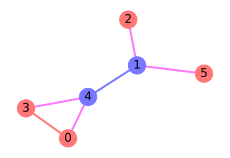

In [582]:
n = 6; A = {0, 3, 5, 2}; B = {1, 4}
G = nx.gnp_random_graph(n, 0.5, seed=0)
plt.figure(figsize=(3,2))
hl = lambda xs, X: 'ff' if any(x in X for x in xs) else '77'
node_color = [f"#{hl([i],A)}77{hl([i],B)}" for i in range(n)]
edge_color = [f"#{hl(e, A)}77{hl(e,B)}" for e in G.edges]
nx.draw(G, labels=dict(enumerate(range(n))), pos=nx.kamada_kawai_layout(G),
        node_color=node_color, edge_color=edge_color, width=2); plt.show()

The MAX-CUT problem can be formulated as a constraint satisfaction problem, where each edge $\{i, j\} \in E$ corresponds to the constraint that nodes $i$ and $j$ must not be both in $A$ or both in $B$. Numbering the nodes ${0,...,n-1}$, we can encode a partition into a bitstring $b_0...b_{n-1}$, where $b_i = 0$ means that $i \in A$ and $b_i = 1$ means that $i \in B$. Whence, we get the following constraint for edge $\{i, j\} \in E$:

$$
\varphi_{\{i,j\}}
:=
b_i \oplus b_j
=
\begin{cases}
1 &\text{ if } i \neq j\\
0 &\text{ if } i = j
\end{cases}
$$

The problem Hamiltonian for MAX-CUT is then:

$$
H_{\text{maxcut}(V,E)}
:=
\sum_{\{i,j\} \in E} \varphi_{\{i,j\}}
=
\sum_{\{i,j\} \in E} H_{b_i \oplus b_j}
=
\sum_{\{i,j\} \in E} \text{Z}_{q_i}\text{Z}_{q_j}
$$

In [1551]:
n = 6; G = nx.gnp_random_graph(n, 0.5, seed=0)
def H_maxcut(G):
    n = len(G.nodes)
    edge_constraints = [c_xor(c_bit(i, n), c_bit(j, n)) for i, j in G.edges]
    return H_sumprod(*edge_constraints)
print(H:=H_maxcut(G))

{'IIZIIZ': 1.0, 'IZIIIZ': 1.0, 'IIIZZI': 1.0, 'IZIIZI': 1.0, 'ZIIIZI': 1.0, 'IZZIII': 1.0}


For the 6-node random graph previously displayed, we get:

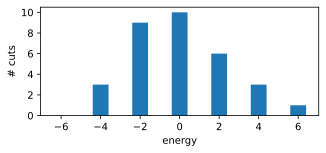

In [818]:
energy_levels = {e: set() for e in range(-n, n+1)}
for A_idx in range(2**n):
    A = frozenset(i for i in range(n) if A_idx&(2**i))
    B = frozenset(i for i in range(n) if i not in A)
    cut = frozenset([A,B])
    bitstr = ''.join("0" if i in A else "1" for i in range(n))[::-1]
    e = energy(H, bitstr)
    energy_levels[e].add(cut)
plt.figure(figsize=(5,2)); plt.yticks(range(0,11,2))
plt.bar(list(energy_levels), [len(cuts) for cuts in energy_levels.values()])
plt.xlabel("energy"); plt.ylabel("# cuts"); plt.show()

While energy is the natural quantity to minimize, cut size is the quantity of interest in this problem (to be maximized):

$$
\text{cut size}
=
\text{# satisfied constraints}
=
\frac{1}{2}\left(
\text{# constraints}-\text{energy}
\right)
$$

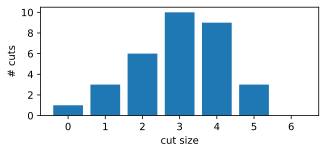

In [819]:
plt.figure(figsize=(5,2)); plt.yticks(range(0,11,2))
plt.bar([0.5*(len(G.edges)-e) for e in energy_levels],
        [len(cuts) for cuts in energy_levels.values()])
plt.xlabel("cut size"); plt.ylabel("# cuts"); plt.show()

Below we display the three max cuts for this graph, all of size 5:

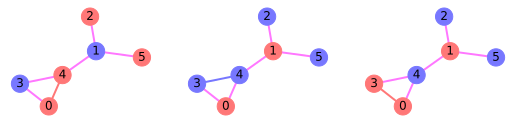

In [635]:
plt.figure(figsize=(9,2))
for i, cut in enumerate(energy_levels[-4]): # cut size 5
    plt.subplot(131+i); A, B = list(cut)
    hl = lambda xs, X: 'ff' if any(x in X for x in xs) else '77'
    node_color = [f"#{hl([i],A)}77{hl([i],B)}" for i in range(n)]
    edge_color = [f"#{hl(e, A)}77{hl(e,B)}" for e in G.edges]
    nx.draw(G, labels=dict(enumerate(range(n))), pos=nx.kamada_kawai_layout(G),
            node_color=node_color, edge_color=edge_color, width=2)
plt.show()

We attempt to find optimal MAX-CUT solutions using VQE. As an ansatz, we consider a layer of Hadamards (i.e. we take $|+...+\rangle$ as starting state) followed by a layer of trainable Y rotations.

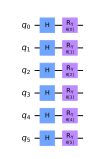

In [822]:
def maxcut_ansatz(G: nx.Graph) -> QuantumCircuit:
    n = len(G.nodes)
    params = make_params(n)
    circ = QuantumCircuit(n)
    circ.h(range(n))
    for q, p in enumerate(params):
        circ.ry(p, q)
    return circ
maxcut_ansatz(G).draw("mpl", scale=0.5)

In [821]:
def make_maxcut_obj_fun(G: nx.Graph, backend=simulator, **kwargs):
    hist = {"obj_val": [], "param_vals": []}
    ansatz = maxcut_ansatz(G); n = len(G.nodes)
    H = H_maxcut(G)
    def obj_fun(param_vals):
        assert len(param_vals) == n
        state_prep = ansatz.assign_parameters(dict(zip(ansatz.parameters, param_vals)))
        obj_val = obs_expval(state_prep, H, backend=backend, **kwargs)
        hist["obj_val"].append(obj_val)
        hist["param_vals"].append(param_vals)
        return obj_val
    return obj_fun, hist

We run a handful of optimisations, with slight variations initial parameter values: 

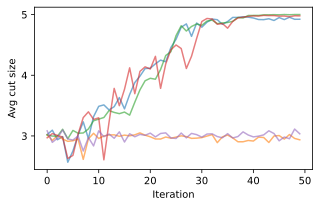

In [826]:
rng = np.random.default_rng(seed=0)
n = 6; G = nx.gnp_random_graph(n, 0.5, seed=0)
optimizer = COBYLA(maxiter=50)
opt_param_vals_list = []
plt.figure(figsize=(5,3)); plt.yticks(range(0, 6))
for _ in range(5):
    init_param_vals = rng.uniform(-0.1, 0.1, size=n)
    obj_fun, hist = make_maxcut_obj_fun(G)
    opt, e, _ = optimizer.optimize(n, obj_fun, initial_point=init_param_vals)
    opt_param_vals_list.append(opt)
    plt.plot(0.5*(len(G.edges)-np.array(hist["obj_val"])), alpha=0.6)
plt.xlabel("Iteration"); plt.ylabel("Avg cut size"); plt.show()

Looking at the optimal parameters for one of the successful optimisation runs, we see that the state $|000011\rangle$ has been reached to good approximation, corresponding to the max cut $\{\{0,1\},\{2,3,4,5\}\}$:

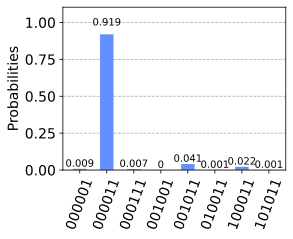

<Figure size 864x144 with 0 Axes>

In [847]:
circ = maxcut_ansatz(G); n = len(G.nodes); H = H_maxcut(G)
circ.measure_all()
counts = execute(circ.bind_parameters(dict(zip(circ.parameters, opt_param_vals_list[0]))),
                 simulator, shots=2000).result().get_counts()
plot_histogram(counts, figsize=(4,3))

## Ising Hamiltonians

**Ising Hamiltonians** are a special class of problem Hamiltonians, where the number of $\text{Z}$s appearing in any Paulistring with $\lambda_\underline{P}!=0$ is at most 2. This means that Ising Hamiltonians $H$ can be expressed in terms of an underlying "entanglement graph" $G_H$:

$$
H
=
\sum_{\{i,j\} \in G_H} J_{\{i,j\}} \text{Z}_{q_i} \text{Z}_{q_j}
+
\sum_{i=0}^{n-1} h_{i} \text{Z}_{q_i}
+
D
$$

The $h_i$ coefficients are known as **biases**, while the $J_{\{i,j\}}$ coefficients are known as **couplings**. For example, MAX-CUT Hamiltonians $H_{maxcut(G)}$ are Ising Hamiltonians, with $G$ as the underlying entanglement graph and $J_e = 1$ for all edges $e \in G$.

In [ ]:
def H_ising_validate(H: Mapping[str, float]) -> int:
    n = H_prob_validate(H)
    assert all(paulis.count("Z") <= 2 for paulis in H)
    return n
n = 6; G = nx.gnp_random_graph(n, 0.5, seed=0)
H_ising_validate(H_maxcut(G))

We can draw Ising Hamiltonians as graphs:

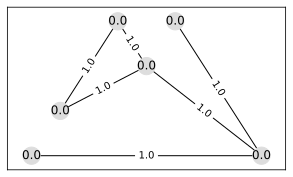

In [1194]:
def draw_ising(H: Mapping[str, float], **kwargs) -> None:
    n = H_ising_validate(H)
    _H = {tuple(q for q, p in enumerate(paulis) if p == "Z"): coeff
                 for paulis, coeff in H.items()}
    biases = {paulis: coeff for paulis, coeff in _H.items() if len(paulis) == 1}
    couplings = {paulis: coeff for paulis, coeff in _H.items() if len(paulis) == 2}
    G = nx.Graph()
    G.add_nodes_from(list(range(n)))
    G.add_edges_from(list(couplings))
    pos = nx.planar_layout(G)
    node_labels = {q: f"{biases.get((q,), 0.0):.1f}" for q in range(n)}
    edge_labels = {e: f"{coeff:.1f}" for e, coeff in couplings.items()}
    nx.draw_networkx(G, pos, labels=node_labels, node_color = "#dddddd", **kwargs)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
n = 6; G = nx.gnp_random_graph(n, 0.5, seed=0)
plt.figure(figsize=(5,3)); draw_ising(H_maxcut(G)); plt.show()

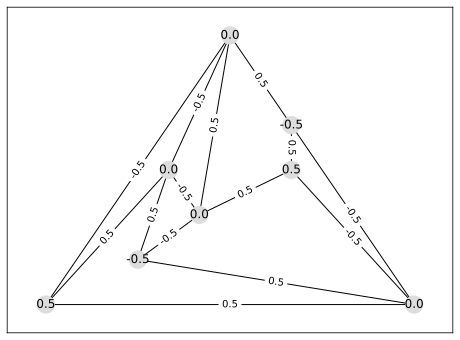

In [1339]:
nvars = 8; b = [c_bit(i, nvars) for i in range(nvars)]
constraints = [c_and(b[i], c_neg(b[(i+2)%nvars])) for i in range(nvars)]
constraints += [c_or(c_neg(b[i]), b[(i+3)%nvars]) for i in range(1,nvars-1)]
H = H_sumprod(*constraints)
plt.figure(figsize=(8,6)); draw_ising(H); plt.show()

## Trotterization

The [Trotter-Suzuki formula](https://en.wikipedia.org/wiki/Lie_product_formula) gives us a way to (approximately) realize the rotation $\exp\left(-i tH\right)$ for an arbitrary Hamiltonian $H$, by performing many small rotations in sequence. If $K$ is large, then $\frac{t}{K}$ is small, so the matrices $-i \frac{t \lambda_\underline{P}}{K}\underline{P}$ are all close to zero and hence approximately commute:

$$
\begin{align*}
H &= \sum_{\underline{P}} \lambda_\underline{P} \bigotimes_{i=0}^{n-1} P_{q_i}
\\
\exp\left(-i t H\right)
&=
\prod_{k=0}^{K-1}
\exp\left(-i \frac{t}{K} H\right)
\approx
\prod_{k=0}^{K-1}
\prod_{\underline{P}} \exp\left(-i \frac{t \lambda_\underline{P}}{K} \bigotimes_{i=0}^{n-1} P_{q_i}\right)
\end{align*}
$$

$$
\begin{align*}
H &= \sum_{\underline{P}} \lambda_\underline{P} \bigotimes_{i=0}^{n-1} P_{q_i}
\\
\exp\left(-i t H\right)
&=
\prod_{k=0}^{K-1}
\exp\left(-i \frac{t}{K} H\right)
\approx
\prod_{k=0}^{K-1}
\prod_{\underline{P}} \exp\left(-i \frac{t \lambda_\underline{P}}{K} \bigotimes_{i=0}^{n-1} P_{q_i}\right)
\end{align*}
$$

This procedure is known as _Trotterization_: decomposing a complex evolution into many repetitions of short term alternating sequences of simpler evolutions. By using Trotterization together with Pauli gadgets, we can now simulate the evolution of any quantum system on a quantum computer. We can even use different time lengths $\delta t_0, ..., \delta t_{K-1} > 0$ for the individual slices, as long as they are all small and $\sum_{k=0}^{K-1} \delta t_k = t$ (setting $\delta t_k=\frac{t}{K}$ is the simplest choice).

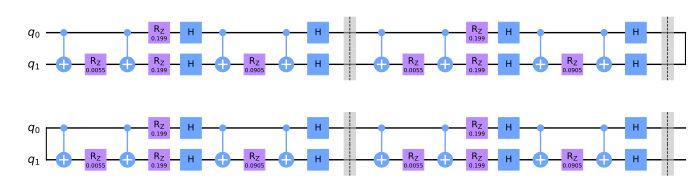

In [297]:
def trotterize(H: Mapping[str, float], K: int, *, t: float) -> QuantumCircuit:
    n = len(list(H)[0]); assert all(len(paulis) == n for paulis in H)
    circ = QuantumCircuit(n)
    for k in range(K):
        dt_k = t/K
        for paulis, coeff in H.items():
            circ.compose(pauli_gadget(paulis, 2*coeff*dt_k), inplace=True)
        circ.barrier()
    return circ
H = {"ZZ": 0.011, "ZI": 0.398, "IZ": 0.398, "XX": 0.181}
trotterize(H, 4, t=1).draw("mpl", scale=0.7, fold=20)

In the following set of examples, we look at $H = \frac{\omega}{2}\frac{\text{X}+\text{Z}}{\sqrt{2}}$, which rotates about the axis through $\frac{|+\rangle+|0\rangle}{\sqrt{2}}$ by an angle of $\omega$ in a unit time interval (e.g. from $t=0$ to $t=1$). Below we trace $U(t)|0\rangle = e^{-itH}|0\rangle$ for $t \in [0,1]$, for angular velocity $\omega=2\pi$. Note how increasing values of $K$ lead to better trotterized approximations of $U(t)$.

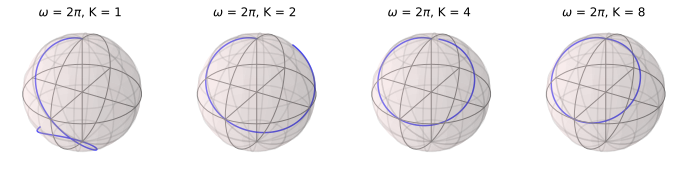

In [443]:
w = 2*pi # angular velocity
H = {"X": w/(2*sqrt(2)), "Z": w/(2*sqrt(2))}
fig = plt.figure(figsize=(12,3))
for i, K in enumerate([1,2,4,8]):
    B = Bloch(axes=plt.subplot(141+i, projection="3d"))
    B.zlabel=["",""]; B.xlabel=["",""]; B.ylabel=["",""]
    states = [trotterize(H, K, t=t) for t in np.linspace(0, 1, math.ceil(50*w/pi))]
    bloch_data = np.array([np.array(bloch_multivector_data(state)[0])
                           for state in states])
    B.add_points([bloch_data[:,i] for i in range(3)], "l")
    B.font_size=12; B.render(title=f"$\omega$ = {w/pi:.0f}$\pi$, {K = }")

However, a drift in the $K=8$ approximation becomes apparent at higher angular velocity $\omega = 8\pi$ (or, equivalently, by letting $t$ go to $4$ for $\omega = 2\pi$).

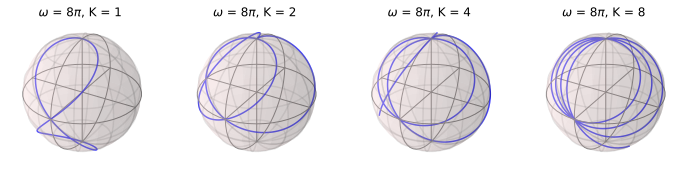

In [446]:
w = 8*pi # angular velocity
H = {"X": w/(2*sqrt(2)), "Z": w/(2*sqrt(2))}
fig = plt.figure(figsize=(12,3))
for i, K in enumerate([1,2,4,8]):
    B = Bloch(axes=plt.subplot(141+i, projection="3d"))
    B.zlabel=["",""]; B.xlabel=["",""]; B.ylabel=["",""]
    states = [trotterize(H, K, t=t) for t in np.linspace(0, 1, math.ceil(50*w/pi))]
    bloch_data = np.array([np.array(bloch_multivector_data(state)[0])
                           for state in states])
    B.add_points([bloch_data[:,i] for i in range(3)], "l")
    B.font_size=12; B.render(title=f"$\omega$ = {w/pi:.0f}$\pi$, {K = }")

Increasing $K$ further leads to better trotterized approximations (smaller drift). This is generally the case with trotterization: higher angular velocities (i.e. larger coefficients in the Hamiltonian) require more trotterization steps.

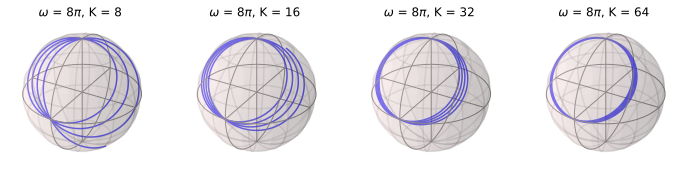

In [447]:
w = 8*pi # angular velocity
H = {"X": w/(2*sqrt(2)), "Z": w/(2*sqrt(2))}
fig = plt.figure(figsize=(12,3))
for i, K in enumerate([8,16,32,64]):
    B = Bloch(axes=plt.subplot(141+i, projection="3d"))
    B.zlabel=["",""]; B.xlabel=["",""]; B.ylabel=["",""]
    states = [trotterize(H, K, t=t) for t in np.linspace(0, 1, math.ceil(50*w/pi))]
    bloch_data = np.array([np.array(bloch_multivector_data(state)[0])
                           for state in states])
    B.add_points([bloch_data[:,i] for i in range(3)], "l")
    B.font_size=12; B.render(title=f"$\omega$ = {w/pi:.0f}$\pi$, {K = }")

## Time-dependent Hamiltonians

For quantum systems with a time-independent Hamiltonian, we have previously seen that:

$$
|\psi_t\rangle
=
U(t)|\psi_0\rangle
\hspace{2cm}
U(t)
:=
e^{-i tH}
\hspace{2cm}
\frac{d}{dt}U(t)
=
-i H \,U(t)
$$

However, it is possible for the Hamiltonian $H(t)$ itself to have some time-dependence, e.g. because we change the parameters of a controlled quantum system. This is, indeed, how quantum computers are implemented in practice: the Hamiltonian of the underlying quantum system is changed in precisely the way required for evolution to perform the desired quantum gates. Under mild assumptions on $H(t)$, [Stone's theorem](https://en.wikipedia.org/wiki/Stone%27s_theorem_on_one-parameter_unitary_groups) generalises to the time-dependent case:

$$
\frac{d}{dt}U(t)
=
-i H(t)U(t)
$$

Equivalently, the dynamics as a whole can be expressed as a [time-ordered exponential](https://en.wikipedia.org/wiki/Ordered_exponential), a sophisticated mathematical construction originally developed for perturbative quantum field theory (see e.g. [time-ordering](https://en.wikipedia.org/wiki/Path-ordering#Time_ordering) and the [Dyson series](https://en.wikipedia.org/wiki/Dyson_series)):

$$
U(t) = \mathcal{T} \exp\left(\int_0^t -i H(t') dt'\right)
$$

This is similar to the exponential $e^{-i tH}$. Each term in the series requires $k$ integrations, ensuring that time variables appear in the correct order: for $0\leq t'_1 \leq... \leq t'_k \leq t$, we must have $A(t'_j)$ appearing at the left of $A(t'_i)$&mdash;i.e. being applied after $A(t'_i)$&mdash;whenever $j > i$:

$$
\begin{align*}
&\mathcal{T} \exp\left(\int_0^t A(t') dt'\right)
\\
=&
\sum_{k=0}^\infty
\frac{1}{k!}
\int_0^{t}
\!\!dt'_{k}
\int_0^{t'_{k}}
\!\!dt'_{k-1}
...
\int_0^{t'_{2}}
\!\!\!dt'_{1}
\;
A(t'_{k})
A(t'_{k-1})
...
A(t'_{1})
\end{align*}
$$

How do we implement this really complicated unitary on a quantum computer?

Because of its decomposition into "infinitesimal" time steps, Trotterization can also be used to approximate the time-ordered exponential of a time-dependent Hamiltonian, with minor modification:

$$
H(t) = \sum_{\underline{P}} \lambda_\underline{P}(t) \underline{P}
\hspace{2cm}
\mathcal{T} \exp\left(\int_0^t -i H(t) dt\right)
\approx
\prod_{k=0}^{K-1}
\prod_{\underline{P}} \exp\left(-i \,\delta t_k \,\lambda_\underline{P}\!\left(t_k\right) \bigotimes_{i=0}^{n-1} P_{q_i}\right)
$$

where $\delta t_{0},...,\delta t_{K-1}$ are possibly uneven time steps and $t_k \in \left[\sum_{k'=0}^{k-1}\delta t_{k'}, \sum_{k'=0}^{k}\delta t_{k'}\right]$. Setting $\delta t_k = \frac{t}{K}$ and $t_k = (k+\frac{1}{2})\frac{t}{K}$ is a common choice.

**Note.** All ordered products of matrices in this work are to be expanded right-to-left (so that times are ordered $t_0 < t_1 < ...< t_{K-1}$ in the circuit):

$$
\begin{align*}
&\mathcal{T} \exp\left(\int_0^t -i H(t) dt\right)
\approx
\prod_{k=0}^{K-1}
\prod_{\underline{P}} \exp\left(-i \,\delta t_k \,\lambda_\underline{P}\!\left(t_k\right) \bigotimes_{i=0}^{n-1} P_{q_i}\right)
\\&=
\left[
\prod_{\underline{P}} \exp\left(-i \,\delta t_{K-1} \,\lambda_\underline{P}\!\left(t_{K-1}\right) \bigotimes_{i=0}^{n-1} P_{q_i}\right)
\right]
...
\left[
\prod_{\underline{P}} \exp\left(-i \,\delta t_0 \,\lambda_\underline{P}\!\left(t_0\right) \bigotimes_{i=0}^{n-1} P_{q_i}\right)
\right]
\end{align*}
$$

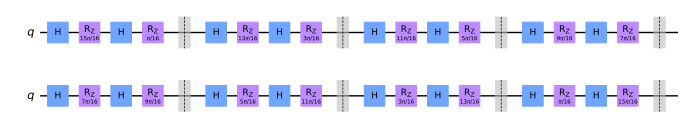

In [769]:
from typing import Callable
def trotterize(H: Mapping[str, Union[float, Callable[[float], float]]],
               K: int, *, t: float = 1.0, barriers: bool = True) -> QuantumCircuit:
    n = len(list(H)[0])
    assert all(len(paulis) == n for paulis in H)
    circ = QuantumCircuit(n)
    for k in range(K):
        dt_k = t/K; t_k = (k+0.5)*dt_k
        for paulis, coeff in H.items():
            if not isinstance(coeff, float):
                coeff = coeff(t_k)
            circ.compose(pauli_gadget(paulis, 2*coeff*dt_k), inplace=True)
        if barriers: circ.barrier()
    return circ
H = {"X": lambda t: 4*pi*(1-t), "Z": lambda t: 4*pi*t}
trotterize(H, 8, t=1).draw("mpl", scale=0.7, fold=20)

## Quantum Annealing

[Quantum Annealing](https://en.wikipedia.org/wiki/Quantum_annealing) relies on the [adiabatic theorem](https://en.wikipedia.org/wiki/Adiabatic_quantum_computation) to (approximately) compute the minimum energy state of a **problem Hamiltonian** $H_{prob}$.

The adiabatic theorem states that, as long as its Hamiltonian is changed slowly enough, a quantum system with time-dependent Hamiltonian $H(t)$ that starts in a minimum energy state for its initial Hamiltonian $H(0)$ will remain close to a minimum energy state of $H(t)$ throughout the entirety of its evolution. Analogously, if the system starts in a maximum energy states for $H(0)$, it will remain close to a maximum energy state for $H(t)$ as $t$ progresses from the initial time $0$ to the final time $T$.

What does "slowly enough" mean? Consider a time-dependent Hamiltonian, written in terms of energy values and eigenspaces:

$$
H(t) = \sum_{E \in \mathcal{E}(t)} E \,\Pi_{E,t}
$$

The set of energy values $\mathcal{E}(t)$ is time-dependent, as are the eigenspace projectors $(\Pi_{E,t})_{E \in \mathcal{E}(t)}$. Let $E_0(t)$ and $E_1(t)$ be the two lowest energy values in $\mathcal{E}(t)$, and define the **spectral gap** $g(t) := E_1(t) - E_0(t) > 0$. The **minimum spectral gap** is the minimum of $g(t)$ over $t \in [0,1]$:

$$
g_{min} := \min\limits_{0 \leq t \leq 1} g(t)
$$

For the purposes of adiabatic quantum computation, "slowly enough" means that the time interval over which the system evolves must be much larger than the inverse squared of the minimum spectral gap (times a typically small constant):

$$
T \gg O\left(\frac{1}{g_{min}^2}\right)
$$

So there are two equivalent ways to obtain better aproximations through quantum annealing:

- quadratically increasing $T$, when the Hamiltonian is physical (e.g. on D-Wave hardware)
- linearly increasing $g_{min}$, when the Hamiltonian is simulated (e.g. on gate-based Hardware)

Here we fix $T = 1$ and instead rescale the Hamiltonian coefficients to obtain better results.

Quantum Annealing exploits this result by choosing an initial Hamiltonian ${H}_{0}$ with a ground state that is very easy to construct. A typical choice for ${H}_{0}$ is the **transverse field Hamiltonian**:

$$
H_{0} = H_{tran}:= -\sum_{i=0}^{n-1} \text{X}_{q_i}
$$

The product state $|+...+\rangle$, easy to construct, is the unique state of minimum energy for this Hamiltonian.
Starting from $H_{init}$, the system Hamiltonian is slowly changed towards the final Hamiltonian $H_{1}$, as time progresses from the initial time $t=0$ to the final time $t=1$:

$$
H(t) = a(t)H_{0} + b(t)H_{1}
\hspace{3cm}
a(0) \gg 0\hspace{5mm}
a(1) = 0\hspace{5mm}
b(0) = 0\hspace{5mm}
b(1) \gg 0
$$

At $t=1$, the quantum system will be in a state close to the minimum energy state for the final Hamiltonian $H_{1}$. To find a maximum energy state for $H_{1}$ instead, one can either change $H_{0}$ to $+\sum_{i=0}^{n=1} \text{X}_{q_i}$ (for which $|+...+\rangle$ is the maximum energy state), or change $|+...+\rangle$ to $|-...-\rangle$ (the maximum energy state of the original $H_{0}$).

The way in which $a(t)$ and $b(t)$ change in time is known as the **annealing schedule**. A common family of annealing schedules is given by the power-laws $a(t) = a_0 (1-t)^p$ and $b(t) = b_1 t^q$, for some exponents $c, d > 0$ and some coefficients $a_0, b_1 \neq 0$:

$$
\begin{align*}
H(t)
&=
a_0(1-t)^c H_{0} + b_1t^d H_{1}
\\&=
b_1\left[\frac{a_0}{b_1}(1-t)^c H_{0} + t^d H_{1}\right]
\end{align*}
$$

The ratio $a_0/b_1$ sets the relative energy scale between the initial and final Hamiltonian; if negative, the annealing algorithm maximises $H_1$ instead of minimizing it. The $b_1$ coefficient sets the overall energy scale for $H(t)$: increasing $b_1 \mapsto x b_1$ also increases the minimum spectral gap $g_{min} \mapsto x g_{min}$, improving the precision of the annealing.

Three symmetric annealing schedules, with $c=d$ and $a_0/b_1=1$:

In [2]:
import numpy as np

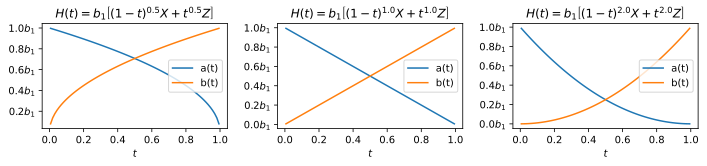

In [13]:
K = 80; t_vals = (np.arange(K)+0.5)/K
plt.figure(figsize=(10, 2.5))
for i, c in enumerate([0.5, 1, 2]):
    plt.subplot(131+i); plt.xlabel("$t$")
    a = lambda t: (1-t)**c; b = lambda t: t**c
    plt.title(fr"$H(t) = b_1\left[(1-t)^{{{c:.1f}}}X+t^{{{c:.1f}}}Z\right]$")
    plt.yticks(np.arange(6)/5, labels=[rf"{x}$b_1$" for x in np.arange(6)/5])
    plt.plot(t_vals, a(t_vals), label="a(t)")
    plt.plot(t_vals, b(t_vals), label="b(t)"); plt.legend(loc="right")
plt.tight_layout(); plt.show()

Two asymmetric annealing schedules, resembling those used on the [D-Wave Advantage system](https://docs.dwavesys.com/docs/latest/doc_physical_properties.html#doc-qpu-characteristics) and the [D-Wave 2x system](https://docs.dwavesys.com/docs/latest/c_qpu_annealing.html#annealing-functions-5us) respectively.

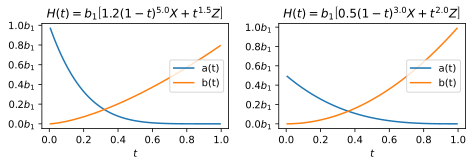

In [1069]:
K = 80; t_vals = (np.arange(K)+0.5)/K
plt.figure(figsize=(10,2.5))
for i, (c, d, alpha) in enumerate([(5,1.5, 1.25), (3, 2, 0.5)]):
    plt.subplot(131+i); plt.xlabel("$t$")
    a = lambda t: alpha*(1-t)**c; b = lambda t: t**d
    plt.title(fr"$H(t) = b_1\left[{alpha:.1f}(1-t)^{{{c:.1f}}}X+t^{{{d:.1f}}}Z\right]$")
    plt.yticks(max(alpha, 1)*np.arange(6)/5, labels=[rf"{x}$b_1$" for x in np.arange(6)/5])
    plt.plot(t_vals, a(t_vals), label="a(t)")
    plt.plot(t_vals, b(t_vals), label="b(t)"); plt.legend(loc="right")
plt.tight_layout(); plt.show()

We want to test various combinations of trotterization steps $K$ and annealing schedule parameters on single-qubit annealing. We take $H_{0} = \text{X}$ and $H_{1} = \text{Z}$, with maxima $|\!+\!\rangle$ and $|0\rangle$ respectively. We start at $|\!+\!\rangle$. From now on, our annealing schedules are all symmetric, with a single coefficient $\sigma$ determining the energy scale and a single exponent $c$:

$$
H(t)
=
\sigma\left[(1-t)^c H_{0} + t^c H_{1}\right]
$$

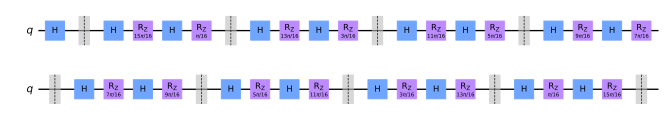

In [1070]:
def state(K: int, *, t: float = 1, c: float = 1, sigma: float = 1) -> QuantumCircuit:
    H = {"X": lambda s: sigma*((1-s)**c),
         "Z": lambda s: sigma*(s**c)}
    circ = QuantumCircuit(1)
    circ.h(0) # init state |+>
    circ.barrier()
    circ.compose(trotterize(H, K, t=t), inplace=True)
    return circ
state(8, sigma=4*pi).draw("mpl", scale=0.65, fold=21)

The states of maximum energy for $H(t)$ migrate from $|+\rangle$ to $|0\rangle$ as $t$ goes from 0 to 1, along the meridian between the two extremes. The migration path is independent of annealing schedule parameters (although the speed along the path depends on them).

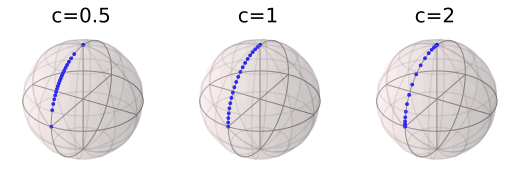

In [1071]:
zero = np.array([1,0]); plus = np.array([1,1])/sqrt(2)
p = 1
fig = plt.figure(figsize=(9,3))
for i, c in enumerate([0.5, 1, 2]):
    B = Bloch(axes=plt.subplot(131+i, projection="3d")); B.point_size[0]=8
    B.xlabel = ["",""]; B.ylabel=["",""]; B.zlabel = ["",""]
    states = [(((1-t)**c)*plus+(t**c)*zero) for t in np.linspace(0, 1, 20)]
    states = [state/np.linalg.norm(state) for state in states]
    bloch_data = np.array([np.array(bloch_multivector_data(state)[0])
                           for state in states])
    B.add_points([bloch_data[:,i] for i in range(3)])
    B.render(title=f"{c=}")

Below we track $U(t)|+\rangle$ for different energy scales $a_0 = b_1 = 2.5, 5, 10$ (blue, red and green, resp) and exponents $c = 0.5, 0.75, 1, 1.5$ (spheres left to right). We see how higher energy scales mean that the evolution tracks more closely the maxima of the intermediate Hamiltonians (migrating north on the meridian from $|+\rangle$ to $|0\rangle$).

Wall time: 2min 32s


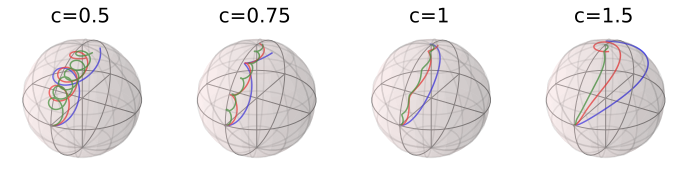

In [1072]:
K = 40
fig = plt.figure(figsize=(12,3))
for i, c in enumerate([0.5, 0.75, 1, 1.5]):
    B = Bloch(axes=plt.subplot(141+i, projection="3d"))
    B.xlabel = ["",""]; B.ylabel=["",""]; B.zlabel = ["",""]
    for sigma in [5, 10, 20]:
        states = [state(K, t=t, c=c, sigma=sigma)
                  for t in np.linspace(0, 1, int(10*beta))]
        bloch_data = np.array([np.array(bloch_multivector_data(state)[0])
                               for state in states])
        B.add_points([bloch_data[:,i] for i in range(3)], "l")
    B.render(title=f"{c=}")

Below we observe how smaller numbers $K$ of trotterization steps affects high-energy paths more than low-energy ones.

Wall time: 1min 16s


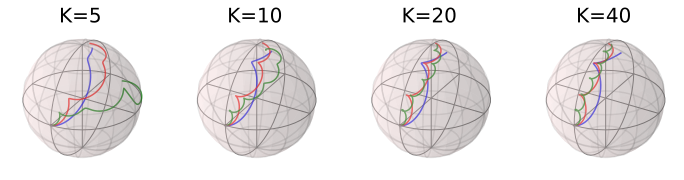

In [1073]:
c = 0.75
fig = plt.figure(figsize=(12,3))
for i, K in enumerate([5, 10, 20, 40]):
    B = Bloch(axes=plt.subplot(141+i, projection="3d"))
    B.xlabel = ["",""]; B.ylabel=["",""]; B.zlabel = ["",""]
    for sigma in [5, 10, 20]:
        states = [state(K, t=t, c=c, sigma=sigma)
                  for t in np.linspace(0, 1, int(10*beta))]
        bloch_data = np.array([np.array(bloch_multivector_data(state)[0])
                               for state in states])
        B.add_points([bloch_data[:,i] for i in range(3)], "l")
    B.render(title=f"{K=}")

Finally, we plot the evolution for $\beta = 50$, which corresponds to very slow change of the Hamiltonian, at a high number of trotterization steps $K=500$. We see how $U(t)|+\rangle$ tracks very closely the minimum of $H(t)$ as $t$ progresses from 0 to 1.

Wall time: 4min 2s


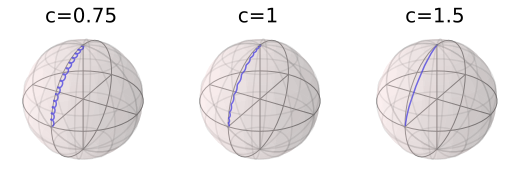

In [1074]:
K = 500; sigma=50
plt.figure(figsize=(9,3))
for i, c in enumerate([0.75, 1, 1.5]):
    B = Bloch(axes=plt.subplot(131+i, projection="3d"))
    B.xlabel = ["",""]; B.ylabel=["",""]; B.zlabel = ["",""]
    states = [state(K, t=t, c=c, sigma=sigma)
              for t in np.linspace(0, 1, 200)]
    bloch_data = np.array([np.array(bloch_multivector_data(state)[0])
                           for state in states])
    B.add_points([bloch_data[:,i] for i in range(3)], "l")
    B.render(title=f"{c=}")

## Quantum Annealing Algorithm

The idea behind the Quantum Annealing Algorithm (QAA) is simple: to minimize a problem Hamiltonian $H_{prob}$, we simulate the evolution of a quantum system with initial Hamiltonian $H_{trans}$ and final Hamiltonian $H_{prob}$. Below is the time-dependent Hamiltonian typically used, together with a Python implementation using power-law annealing schedules:

$$
H_{qaa}(t) = \sigma\left[(1-t)^c H_{tran} + t^c H_{prob}\right]
$$

In [1559]:
def H_qaa(H_prob, *, a: Callable[[float], float], b: Callable[[float], float]):
    n = len(list(H_prob)[0])
    assert all(all(p in {"I", "Z"} for p in paulis) for paulis in H_prob)
    H_tran = {"I"*(n-1-i)+"X"+"I"*i:-1 for i in range(n)}
    return {
        **{paulis: lambda t: coeff*b(t) for paulis, coeff in H_prob.items()},
        **{paulis: lambda t: coeff*a(t) for paulis, coeff in H_tran.items()}
    }
def annealing_schedule(*, c: float = 1.0, sigma: float = 1.0):
    a = lambda s: sigma*((1-s)**c)
    b = lambda s: sigma*(s**c)
    return a, b

To obtain a state of approximate minimum energy for $H_{prob}$, we simply apply the trotterized circuit for $U(1) = \mathcal{T} \exp\left(\int_0^1 -i H(t') dt'\right)$ to the initial state $|+...+\rangle$.

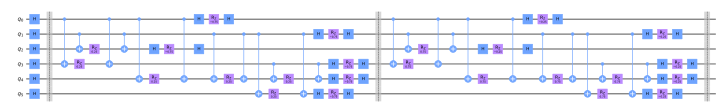

In [1561]:
def qaa_maxcut(G: nx.Graph, K: int, *, t: float = 1,
               a: Callable[[float], float], b: Callable[[float], float],
               barriers: bool = True) -> QuantumCircuit:
    n = len(G.nodes)
    H = H_qaa(H_maxcut(G), a=a, b=b)
    circ = QuantumCircuit(n)
    circ.h(range(n)) # init state |+...+>
    if barriers: circ.barrier()
    circ.compose(trotterize(H, K, t=t, barriers=barriers), inplace=True)
    return circ
n = 6; G = nx.gnp_random_graph(n, 0.5, seed=0)
a, b = annealing_schedule()
qaa_maxcut(G, 2, a=a, b=b).draw("mpl", scale=0.33, fold=46)

Executing the circuit yields a counts dictionary, each bitstring defining a cut. Weighting by bitstring probability, we compute the average cut size for each execution, over a range of trotterization steps $K$ and energy scales $\beta$.

In [1062]:
n = 6; G = nx.gnp_random_graph(n, 0.5, seed=0)
Ks = np.arange(1,21)
sigmas = np.arange(1, 21)
avg_cut_sizes = []
depths = [0]*len(Ks)
H_prob = H_maxcut(G)
for row, sigma in enumerate(sigmas):
    avg_cut_sizes.append([])
    a, b = annealing_schedule(sigma=sigma, c=1)
    for col, K in enumerate(Ks):
        circ = qaa_maxcut(G, K, t=1, a=a, b=b); circ.measure_all()
        depths[K] = circ.depth()
        job = execute(circ, simulator, shots=1000)
        counts = job.result().get_counts()
        avg_energy = sum(count*energy(H_prob, bitstr)for bitstr, count in counts.items())/1000
        avg_cut_sizes[r].append(0.5*(len(G.edges)-avg_energy))

Wall time: 2min 47s


We plot average cut sizes as a function of $K$ and $\sigma$, as well as the (approximate) circuit depth as a function of $K$. We see that the average cut size approaches the theoretical maximum 5 as $K$ and $\sigma$ increase, but also that the necessary circuits are already 100+ gates deep at $K=6$ (without optimization, of course).

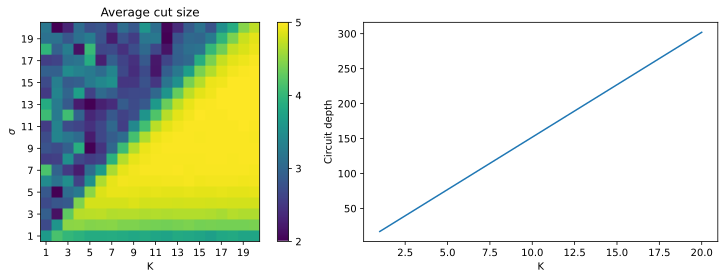

In [1082]:
plt.figure(figsize=(11,4))
plt.subplot(121); plt.title("Average cut size")
plt.xlabel("K"); plt.ylabel(r"$\sigma$")
plt.xticks(range(len(Ks))[::2], Ks[::2])
plt.yticks(range(len(sigmas))[::2], sigmas[::2])
plt.imshow(avg_cut_sizes, vmin=2, vmax=5, origin="lower")
plt.colorbar(ticks=range(2,6))
plt.subplot(122)
plt.xlabel("K"); plt.ylabel("Circuit depth"); plt.plot(Ks, depths)
plt.tight_layout(); plt.show()

In [1340]:
Ks = np.arange(1,21)
sigmas = np.arange(1, 21)
avg_cut_sizes = {}
for n in [5, 10, 15]:
    G = nx.gnp_random_graph(n, 0.5, seed=0)
    H_prob = H_maxcut(G); avg_cut_sizes[n] = []
    for row, sigma in enumerate(sigmas):
        avg_cut_sizes[n].append([])
        a, b = annealing_schedule(sigma=sigma, c=1)
        for col, K in enumerate(Ks):
            circ = qaa_maxcut(G, K, t=1, a=a, b=b, barriers=False); circ.measure_all()
            job = execute(circ, simulator, shots=1000)
            counts = job.result().get_counts()
            avg_energy = sum(count*energy(H_prob, bitstr)for bitstr, count in counts.items())/1000
            avg_cut_sizes[n][row].append(0.5*(len(G.edges)-avg_energy))
    avg_cut_sizes[n] = np.array(avg_cut_sizes[n])

Wall time: 22min 40s


As the number of variables grows, we see that more and more trotterization steps $K$ are needed to discover cuts of maximum size with high probability.

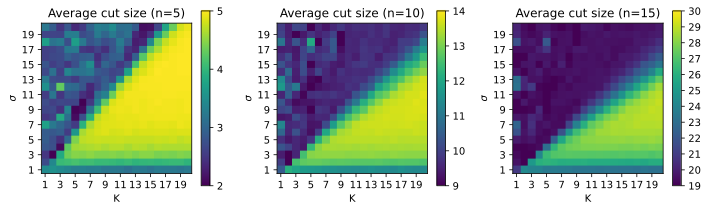

In [1341]:
plt.figure(figsize=(10,3))
for i, n in enumerate(avg_cut_sizes.keys()):
    plt.subplot(131+i); plt.title(f"Average cut size ({n=})")
    plt.xlabel("K"); plt.ylabel(r"$\sigma$")
    plt.xticks(range(len(Ks))[::2], Ks[::2])
    plt.yticks(range(len(sigmas))[::2], sigmas[::2])
    vmin = int(np.floor(np.quantile(avg_cut_sizes[n], 0.1)))
    vmax = int(np.ceil(np.max(avg_cut_sizes[n])))
    plt.imshow(avg_cut_sizes[n], vmin=vmin, vmax=vmax, origin="lower")
    plt.colorbar(ticks=range(vmin, vmax+1))
plt.tight_layout(); plt.show()

We compute the probability distribution on cuts at various time parameters.

In [1505]:
n = 6; G = nx.gnp_random_graph(n, 0.5, seed=0)
K = 20; sigma = 8; shots = 1000
a, b = annealing_schedule(sigma=sigma, c=1)
H_prob = H_maxcut(G)
counts_dict = {}; ts = np.linspace(0, 1, 11)
for t in ts:
    circ = qaa_maxcut(G, K, t=t, a=a, b=b); circ.measure_all()
    counts = execute(circ, simulator, shots=shots).result().get_counts()
    counts_dict[t] = counts

Wall time: 8.17 s


Energy landscape for $H_{prob}$ for computational basis states in [Gray code](https://en.wikipedia.org/wiki/Gray_code).

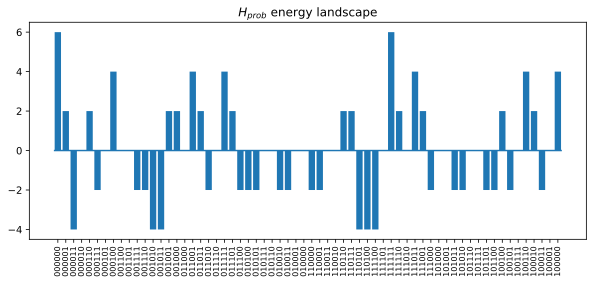

In [1540]:
def gray_code(n: int) -> int:
    return tuple(f"{x^x>>1:0>{n}b}" for x in range(2**n))
bs = gray_code(n)
energies = np.array([energy(H_prob, b) for b in bs])
plt.figure(figsize=(10, 4)); plt.title("$H_{prob}$ energy landscape")
plt.hlines(0, -0.5, 2**n-0.5); plt.bar(bs, energies, width=0.8)
plt.xticks(bs, rotation=90, size=8); plt.show()

As time progresses from $t=0$ to $t=1$, the outcome probabilities concentrate on the 6 computational basis states of minimum energy (corresponding to the 6 max cuts).

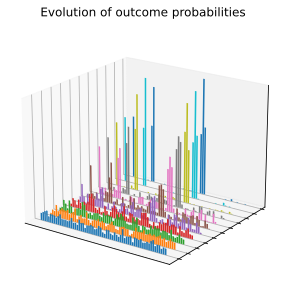

In [1536]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(projection='3d')
bs = gray_code(n)
for t in np.linspace(0, 1, 11):
    probs = [counts_dict[t].get(b, 0)/shots for b in bs]
    ax.bar(range(2**n), probs, zs=t-0.03, zdir="y")
ax.view_init(20,-55)
ax.set_xticks([]); ax.set_zticks([]); plt.yticks(ts,labels=[""]*11)
plt.title("Evolution of outcome probabilities"); plt.show()

## D-Wave Quantum Annealers

Quantum annealers, such as the [D-Wave quantum processing units (QPUs)](https://www.dwavesys.com/quantum-computing), provide a large scale QAA alternative to gate-based quantum computing. When operating D-Wave QPUs, the transverse field $-a(t)\text{X}_{q_i}$, time-dependent biases $b(t)h_{i}Z_{q_i}$ and time-dependent couplings $b(t) J_{\{i,j\}} Z_{q_i} Z_{q_j}$ are set as physical quantities on the flux qubits of the D-Wave QPUs.

Quantum annealers are specialised quantum hardware: natively, they can only perform the Quantum Annealing Algorithm.  However, it can be shown [doi:10.1137/080734479](https://doi.org/10.1137/080734479) that QAA is equivalent to gate-based quantum computing, as long as the fidelity of the annealing process is sufficiently high.

Qubit topologies on D-Wave QPUs display significantly higher connectivity than those currently implemented by super-conducting gate-based quantum computers. The graph $G$ defining the Ising Hamiltonian must be embedded into the qubit topology, so that couplings between logical qubits in the Hamiltonian are mapped to couplings between nearest-neighbours physical qubits.

It might also be necessary to re-scale all biases and couplings by a common factor to ensure that they fall withing the bias/coupling value ranges for the physical QPU. Care has to be taken when the biases/couplings in the Hamiltonian feature large relative differences: when re-scaling, some values might fall below the noise/precision thresholds for the physical QPU.

Below is an example where a cyclic graph $G$ on 4 nodes is embedded into the topology of a D-Wave 2000Q QPU:

- biases $h_0 = 2$, $h_1 = -1$, $h_2 = -2$, $h_3 = 1$
- couplings $J_{0,1} = 1$, $J_{1,2} = 2$, $J_{2,3} = -1$, $J_{3,0} = -2$

A solution of minimum energy $-8$ is also displayed: $s_0 = +1$, $s_1 = s_2 = s_3 = -1$.

<div align="center">
<img src="images/dwave_embedding_cycle.jpg" alt="" width="80%"/>

</div>

Below is a unit cell in the \[16, 16, 4\] Chimera topology of the D-Wave 2000Q QPU: a complete bipartite $K_{4,4}$ graph, partially connected to its 4 nearest neighbour. The full topology contains a 16x16 grid of cells, for a total of 2048 qubits. (A solution is displayed purely for cosmetic reasons.)

<div align="center">
<img src="images/dwave_chimera_topology.jpg" alt="" width="50%"/>

</div>

Below is the unit cell for the Pegasus topology of the D-Wave Advantage QPU. It resembles the unit $K_{4,4}$ cell of the Chimera topology, but with 4 additional couplers between pairs of corresponding outer-inner qubits (making it the 5-regular non-planar graph [$\overline{2C_4}$](https://graphclasses.org/smallgraphs.html#g2C4), the complement of 2 disjoint 4-cycles). The topology contains around 700 such cells, each connected to 10 around neighbouring cells:

<div align="center">
<img src="images/dwave_pegasus_topology.jpg" alt="" width="60%"/>

</div>

Below is MAX-CUT instance on 20 nodes (edges sampled independently with $12\%$ probability), running on the D-Wave 2000Q QPU. QUBO is a formulation of boolean CSPs equivalent to problem/Ising Hamiltonians, but using $\{0,1\}$-valued variables (the bits $b_i$) to express the Hamiltonian instead of $\{\pm 1\}$-valued variables (the eigenvalues of $\text{Z}_{q_i}$).

<div align="center">
<img src="images/dwave_maxcut_20_qubit.jpg" alt="" width="100%"/>

</div>

In this example, a single logical qubit in the problem was implemented by a chain of 4 strongly coupled qubits:

<div align="center">
<img src="images/dwave_maxcut_20_logical_qubit.jpg" alt="" width="100%"/>

</div>

Below is MAX-CUT instance on 1000 nodes (edge sampled independently with $0.272\%$ probability), running on the 5760-qubit Advantage QPU. 

<div align="center">
<img src="images/dwave_maxcut_1000.jpg" alt="" width="100%"/>

</div>

The histogram of sample energies, with the best solution highlighted (cut of size 932).

<div align="center">
<img src="images/dwave_maxcut_1000_hist.jpg" alt="" width="100%"/>

</div>

## QAOA

The **Quantum Approximate Optimization Algorithm [(QAOA)](https://arxiv.org/abs/1411.4028)** is a variational implementation of the Quantum Annealing Algorithm (QAA), with additional optimality guarantees. It follows the same trotterization strategy, alternating rotations for the problem Hamiltonian $H_{prob}$ (writen $H_C$ below, for _constraint Hamiltonian_) and the transverse field Hamiltonian (written $H_M$ below, for _mixing Hamiltonian_). The number of trotterization steps $K$ is fixed: it is written $n$ below, but it is often called $p$ in the literature.


<div align="center">
<img src="images/qaoa_intro.jpg" alt="Max-cut Example" width="80%"/>
</div>
Courtesy of <a href="https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html">PennyLane</a>

In QAA, to improve the quality of our solutions we have to increase the overall energy scale for the annealing schedule and consequently increase the number $K$ of trotterization steps (making our circuits longer and noisier).

$$
\mathcal{T} \exp\left(\int_0^t -i H_{qaa}(t) dt\right)
\approx
\prod_{k=0}^{K-1}
\exp\left(-i \delta t_k a(t_k) H_{tran}\right)
\exp\left(-i \delta t_k b(t_k) H_{prob}\right)
$$

In QAOA, instead, the number of trotterization steps is fixed (), while the time steps and annealing schedule are simultaneously optimized as trainable parameters $\underline{\alpha} = (\alpha_k)_{k=0}^{K-1}$ (replacing $\delta t_k a(t_k)$ from QAA) and $\underline{\beta} = (\beta_k)_{k=0}^{K-1}$ (replacing $\delta t_k b(t_k)$ from QAA):

$$
\mathcal{T} \exp\left(\int_0^t -i H_{qaa}(t) dt\right)
\approx
\prod_{k=0}^{K-1}
\exp\left(-i \alpha_k H_{tran}\right)
\exp\left(-i \gamma_k H_{prob}\right)
$$

<div align="center">
<img src="images/qaoa_intro.jpg" alt="Max-cut Example" width="80%"/>
</div>
Courtesy of <a href="https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html">PennyLane</a>

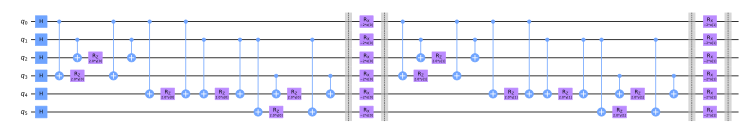

In [1342]:
def qaoa_ansatz(H_prob: Mapping[str, float], K: int,
                *, barriers: bool = True) -> QuantumCircuit:
    n = H_prob_validate(H_prob)
    alphas = make_params(K, label="α")
    gammas = make_params(K, label="γ")
    circ = QuantumCircuit(n)
    circ.h(range(n)) # init state |+...+>
    for k in range(K):
        alpha_k = alphas[k]; gamma_k = gammas[k]
        for paulis, coeff in H_prob.items():
            circ.compose(pauli_gadget(paulis, 2*gamma_k*coeff), inplace=True)
        if barriers: circ.barrier()
        circ.rx(-2*alpha_k, range(n)) # note the negative sign!
        if barriers: circ.barrier()
    return circ
n = 6; G = nx.gnp_random_graph(n, 0.5, seed=0)
qaoa_ansatz(H_maxcut(G), 2).draw("mpl", scale=0.40, fold=46)

In [1228]:
def make_qaoa_obj_fun(H_prob: Mapping[str, float], K: int,
                      *, backend, **kwargs):
    hist = {"obj_val": [], "param_vals": []}
    ansatz = qaoa_ansatz(H_prob, K)
    def obj_fun(param_vals):
        assert len(param_vals) == 2*K
        circ = ansatz.assign_parameters(dict(zip(ansatz.parameters, param_vals)))
        obj_val = obs_expval(circ, H_prob, backend=backend, **kwargs)
        hist["obj_val"].append(obj_val)
        hist["param_vals"].append(param_vals)
        return obj_val
    return obj_fun, hist

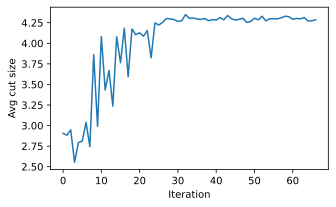

Wall time: 8.18 s


In [1246]:
rng = np.random.default_rng(seed=0)
n = 6; K = 3
G = nx.gnp_random_graph(n, 0.5, seed=0)
plt.figure(figsize=(5,3))
obj_fun, hist = make_qaoa_obj_fun(H_maxcut(G), backend=simulator, K, shots=2000)
optimizer = COBYLA(maxiter=100)
opt_param_vals, min_energy, _ = optimizer.optimize(2*K, obj_fun,
                                                   initial_point=rng.uniform(-0.1, 0.1, size=2*K))
plt.plot(0.5*(len(G.edges)-np.array(hist["obj_val"])))
plt.xlabel("Iteration"); plt.ylabel("Avg cut size"); plt.show()

Measuring the circuit with optimal parameters yields one of the max-cuts with close to 50% probability.

Probability of max cut output: 47%


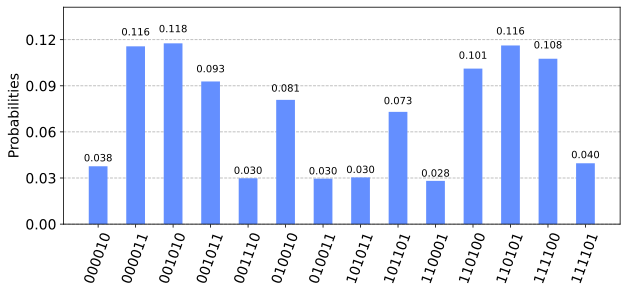

In [1256]:
max_cuts = ["000011", "001010", "001011", "110100", "110101", "111100"]
ansatz = qaoa_ansatz(H_maxcut(G), K)
circ = ansatz.bind_parameters(dict(zip(ansatz.parameters, opt_param_vals)))
circ.measure_all()
shots = 5000; counts = execute(circ, simulator, shots=shots).result().get_counts()
max_cut_prob = sum(counts[max_cut] for max_cut in max_cuts)/shots
print(f"Probability of max cut output: {max_cut_prob:.0%}")
_counts = {bitstr: count for bitstr, count in counts.items() if count >= 0.02*shots}
plot_histogram(_counts, figsize=(10,4))

We try running the same scenario with ADAM and something weird happens... the average cut size is not getting optimised at all! This is because our gradient function is based on the parameter shift rule, which does not apply to the QAOA ansatz: the parameters $\alpha_k$ and $\gamma_k$ are repeated across many rotations.

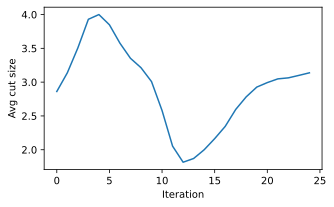

Wall time: 42.5 s


In [1261]:
rng = np.random.default_rng(seed=0)
n = 6; K = 3
G = nx.gnp_random_graph(n, 0.5, seed=0)
optimizer = ADAM(maxiter=25, lr=0.1)
plt.figure(figsize=(5,3))
obj_fun, _ = make_qaoa_obj_fun(H_maxcut(G), K, backend=simulator, shots=2000)
grad_fun, hist = make_grad_fun(obj_fun)
opt_param_vals, min_energy, _ = optimizer.optimize(2*K, obj_fun, gradient_function=grad_fun,
                                                   initial_point=rng.uniform(-0.1, 0.1, size=2*K))
plt.plot(0.5*(len(G.edges)-np.array(hist["obj_val"])))
plt.xlabel("Iteration"); plt.ylabel("Avg cut size"); plt.show()

We now run our algorithm on a larger instance:

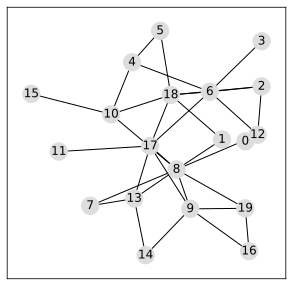

In [1284]:
n = 20; G = nx.gnp_random_graph(n, 0.2, seed=0)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos, labels=dict(enumerate(range(n))), node_color="#dddddd")
plt.show()

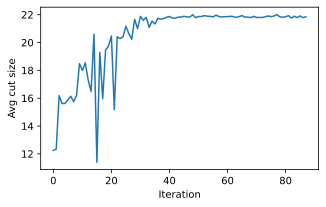

Wall time: 2min


In [1327]:
rng = np.random.default_rng(seed=0)
n = 20; K = 4; G = nx.gnp_random_graph(n, 0.2, seed=0)
plt.figure(figsize=(5,3))
obj_fun, hist = make_qaoa_obj_fun(H_maxcut(G), K, backend=simulator, shots=2000)
optimizer = COBYLA(maxiter=100)
opt_param_vals, min_energy, _ = optimizer.optimize(2*K, obj_fun,
                                                   initial_point=rng.uniform(-0.1, 0.1, size=2*K))
plt.plot(0.5*(len(G.edges)-np.array(hist["obj_val"])))
plt.xlabel("Iteration"); plt.ylabel("Avg cut size"); plt.show()

In [1330]:
ansatz = qaoa_ansatz(H_maxcut(G), K)
circ = ansatz.bind_parameters(dict(zip(ansatz.parameters, opt_param_vals)))
circ.measure_all()
shots = 5000; counts = execute(circ, simulator, shots=shots).result().get_counts()
counts = dict(sorted(counts.items(), key=lambda i: -i[1]))
{bitstr: count for bitstr, count in counts.items() if count >= 6}

{'10000010111011100111': 12,
 '10000011111001100011': 9,
 '01001010101100011101': 9,
 '10110101010010101111': 8,
 '10100101010010101111': 8,
 '10000011111011100011': 7,
 '01011100100111010000': 7,
 '01111101000110011001': 7,
 '00010010111101100100': 7,
 '10111101010011100010': 6,
 '10001010111011100111': 6,
 '01001010101101010001': 6}

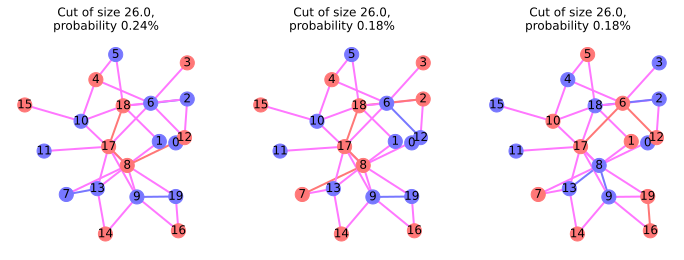

In [1337]:
ncuts = min(len(counts), 3)
plt.figure(figsize=(4*ncuts,4))
H_prob = H_maxcut(G)
hl = lambda xs, X: 'ff' if any(x in X for x in xs) else '77'
for i, (bitstr, count) in enumerate(counts.items()):
    if i >= ncuts: break
    A = {q for q in range(n) if bitstr[n-1-q] == "0"}
    B = {q for q in range(n) if q not in A}
    cutsize = 0.5*(len(G.edges)-energy(H_prob, bitstr))
    plt.subplot(101+10*ncuts+i)
    plt.title(f"Cut of size {cutsize},\nprobability {count/shots:.2%}")
    node_color = [f"#{hl([i],A)}77{hl([i],B)}" for i in range(n)]
    edge_color = [f"#{hl(e, A)}77{hl(e,B)}" for e in G.edges]
    nx.draw(G, labels=dict(enumerate(range(n))), pos=nx.kamada_kawai_layout(G),
            node_color=node_color, edge_color=edge_color, width=2, node_size=200)
plt.show()